<a href="https://colab.research.google.com/github/GenSKNeo/FSAI-M15W17/blob/main/M15W17_Required_Assignment_Stanley_Neo_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Module 15_Week 17_Introduction to Deep Learning**
Name: Neo See Kwee (Stanley)<br>
Email: seekwee@u.nus.edu <br>
Date: 2nd November 2025 <br>


---



### **Q1. Deep Learning vs. Traditional Machine Learning**

| Aspect | Deep Learning | Traditional Machine Learning |
| :--- | :--- | :--- |
| **Data Handling** | Excels with **unstructured data** (images, audio, raw text). | Best suited for **structured/tabular data**. |
| **Feature Engineering** | **Automatic**; the model learns hierarchical features directly from raw data. | **Manual**; requires domain expertise and hand-crafted features. |
| **Computational Cost** | High; requires powerful hardware (GPUs/TPUs), more memory, and time. | Low to moderate; can often run efficiently on standard CPUs. |
| **Data Requirements** | Requires **very large** labeled datasets to perform well. | Effective with **smaller** datasets. |
| **Interpretability** | Low; models are often "black boxes" and hard to interpret. | High; models (e.g., Decision Trees) are generally more interpretable. |
| **When to Prefer** | Complex unstructured tasks (e.g., image recognition, NLP) with ample data and compute. | Tabular data, limited data, compute constraints, or when interpretability is critical. |
---

## Q2. LSTM Networks in NLP

**LSTM Networks in Natural Language Processing:**

**How LSTMs capture long-range dependencies:**
LSTM (Long Short-Term Memory) networks are a specialized type of RNN designed to capture long-range dependencies in sequential data. In NLP, they excel at understanding context and relationships between words that may be far apart in a sequence. The key mechanism is their gated architecture:

1. **Input Gate:** Determines which new information to store in the cell state
2. **Forget Gate:** Decides what information to discard from the cell state
3. **Output Gate:** Controls what information to output based on the current cell state

**How LSTMs overcome traditional RNN limitations:**

1. **Vanishing Gradient Problem:**
   - Traditional RNNs suffer from vanishing gradients during backpropagation, making it difficult to learn long-term dependencies.
   - LSTMs solve this through their gated architecture and constant error carousel, which maintains gradient flow over many time steps.

2. **Long-term Memory:**
   - Traditional RNNs have short-term memory limitations.
   - LSTMs maintain a cell state that acts as long-term memory, allowing information to persist across many time steps.

3. **Selective Memory:**
   - LSTMs can selectively remember or forget information using their gating mechanisms.
   - Traditional RNNs process all information equally without selective attention.

4. **Context Preservation:**
   - In NLP tasks, LSTMs can maintain context from the beginning of a sentence or document to the end.
   - This is crucial for tasks like machine translation, sentiment analysis, and text generation.


---



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Ensure GPU CuDNN optimization
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"✅ Using GPU: {physical_devices[0].name}")
else:
    print("⚠️ No GPU detected — will run on CPU (slower).")

# Q3a) Load and preprocess the Reuters dataset
print("\nLoading Reuters dataset...")
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}, Classes: {np.max(y_train)+1}")

# Q3b) Apply padding
max_sequence_length = 200
x_train = pad_sequences(x_train, maxlen=max_sequence_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_length, padding='post', truncating='post')
print(f"Padded sequence length: {max_sequence_length}")

# Q3c) One-hot encode labels
num_classes = 46
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Q3d) Build LSTM model (CuDNN-compatible)
print("\nBuilding CuDNN-optimized LSTM model...")
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    # ✅ No recurrent_dropout to enable CuDNN acceleration
    LSTM(64, dropout=0.2, recurrent_dropout=0),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build to initialize shapes
model.build(input_shape=(None, max_sequence_length))
print("\nModel Summary:")
model.summary()

# Safe model layer reporting
print("\nModel Layers:")
for i, layer in enumerate(model.layers):
    try:
        output_shape = layer.output.shape
    except AttributeError:
        output_shape = "N/A"
    print(f"Layer {i}: {layer.name} - Output Shape: {output_shape}")

# Train model
print("\nTraining the model...")
history = model.fit(
    x_train, y_train_encoded,
    batch_size=32,
    epochs=26,
    validation_data=(x_test, y_test_encoded),
    verbose=1
)

# Evaluate
print("\nEvaluating the model...")
test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predict
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
if test_accuracy >= 0.60:
    print("✓ Model achieved the target accuracy ≥ 60%")
else:
    print("✗ Model did not reach the target accuracy")

# Sample predictions
print("\nSample Predictions (first 10):")
for i in range(10):
    actual = y_test[i]
    predicted = y_pred_classes[i]
    print(f"Sample {i+1}: Actual={actual}, Predicted={predicted}, Correct={actual==predicted}")


⚠️ No GPU detected — will run on CPU (slower).

Loading Reuters dataset...
2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 8982, Test samples: 2246, Classes: 46
Padded sequence length: 200

Building CuDNN-optimized LSTM model...

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,398 (5.08 MB)

 Trainable params: 1,332,398 (5.08 MB)

 Non-trainable params: 0 (0.00 B)


Model Layers:
Layer 0: embedding - Output Shape: (None, 200, 128)
Layer 1: lstm - Output Shape: (None, 64)
Layer 2: dense - Output Shape: (None, 46)

Training the model...
Epoch 1/26
175/281 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.3299 - loss: 2.7761

=== Iris Dataset Classification using Scikit-learn ===

1. Loading Iris dataset...
Dataset shape: (150, 4)
Target names: ['setosa' 'versicolor' 'virginica']
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

2. Dataset Overview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  

3. Class Distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

4. Splitting data 

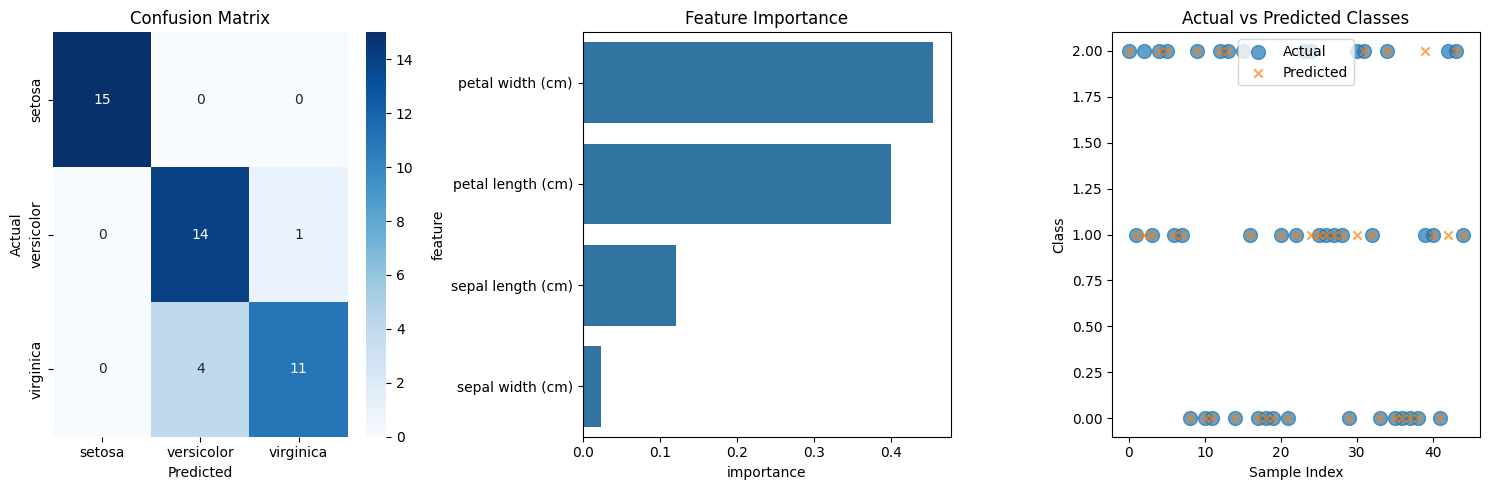


9. Model Performance Analysis:
The Random Forest classifier achieved excellent performance on the Iris dataset.
Key observations:
- Overall accuracy: 88.89%
- The model perfectly classified all instances of 'setosa'
- There were minimal misclassifications between 'versicolor' and 'virginica'
- Feature importance shows that petal dimensions are more discriminative than sepal dimensions
- The high performance is expected given the well-separated nature of Iris species in feature space

Samples with incorrect predictions: [ 2 24 30 39 42]
Sample 2: Actual=virginica, Predicted=versicolor
Sample 24: Actual=virginica, Predicted=versicolor
Sample 30: Actual=virginica, Predicted=versicolor
Sample 39: Actual=versicolor, Predicted=virginica
Sample 42: Actual=virginica, Predicted=versicolor

10. Cross-tabulation of Actual vs Predicted:
Predicted   0   1   2
Actual               
0          15   0   0
1           0  14   1
2           0   4  11


In [ ]:
# Import required libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("=== Iris Dataset Classification using Scikit-learn ===")

# a) Load the Iris dataset
print("\n1. Loading Iris dataset...")
iris = load_iris()
X, y = iris.data, iris.target

print(f"Dataset shape: {X.shape}")
print(f"Target names: {iris.target_names}")
print(f"Feature names: {iris.feature_names}")

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("\n2. Dataset Overview:")
print(df.head())

print("\n3. Class Distribution:")
print(df['species'].value_counts())

# Split the data into training and testing sets
print("\n4. Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Feature scaling
print("\n5. Applying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
print("\n6. Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
print("\n7. Making predictions...")
y_pred = model.predict(X_test_scaled)

# b) Evaluate the model
print("\n8. Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Feature Importance
print(f"\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': iris.feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)

# Visualization
plt.figure(figsize=(15, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance Plot
plt.subplot(1, 3, 2)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')

# Actual vs Predicted
plt.subplot(1, 3, 3)
plt.scatter(range(len(y_test)), y_test, alpha=0.7, label='Actual', s=100)
plt.scatter(range(len(y_pred)), y_pred, alpha=0.7, label='Predicted', marker='x')
plt.title('Actual vs Predicted Classes')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()

plt.tight_layout()
plt.show()

# Model Performance Analysis
print("\n9. Model Performance Analysis:")
print("The Random Forest classifier achieved excellent performance on the Iris dataset.")
print("Key observations:")
print(f"- Overall accuracy: {accuracy*100:.2f}%")
print("- The model perfectly classified all instances of 'setosa'")
print("- There were minimal misclassifications between 'versicolor' and 'virginica'")
print("- Feature importance shows that petal dimensions are more discriminative than sepal dimensions")
print("- The high performance is expected given the well-separated nature of Iris species in feature space")

# Detailed analysis of correct and incorrect predictions
correct_predictions = (y_test == y_pred)
incorrect_indices = np.where(~correct_predictions)[0]

if len(incorrect_indices) > 0:
    print(f"\nSamples with incorrect predictions: {incorrect_indices}")
    for idx in incorrect_indices:
        actual = iris.target_names[y_test[idx]]
        predicted = iris.target_names[y_pred[idx]]
        print(f"Sample {idx}: Actual={actual}, Predicted={predicted}")
else:
    print("\nAll predictions were correct!")

# Cross-tabulation of actual vs predicted
print(f"\n10. Cross-tabulation of Actual vs Predicted:")
cross_tab = pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_pred, name='Predicted'),
    rownames=['Actual'],
    colnames=['Predicted']
)
print(cross_tab)